## Module 2.1: Working with MLPs in Keras (A Review)

This is a quick review of working with MLPs. We want to get everyone on the same level as we proceed. In this module we will pay attention to:
1. Using the Keras functional API for defining models.
2. Implementing different types of regularization.
3. Implementing batch normalization.
4. Working with validation data and early stopping.

Those students who are comfortable with all these matters might consider skipping ahead.

Note that we will not spend time tuning hyper-parameters: The purpose is to show how different techniques can be implemented in Keras, not to solve particular data science problems as optimally as possible. Obviously, most techniques include hyper-parameters that need to be tuned for optimal performance.

In [0]:
# We will always initially perform all required imports
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from IPython.display import SVG

import matplotlib.pyplot as plt

from keras import Sequential
from keras.layers import Input, Dense, GaussianNoise, Dropout 
from keras.layers import BatchNormalization, Activation
from keras.utils.vis_utils import model_to_dot
from keras.models import Model
from keras.constraints import UnitNorm
from keras.regularizers import l2
from keras.callbacks import EarlyStopping


In [7]:
#We will quickly load a simple data set to work with.    
df = pd.read_csv("http://nrvis.com/data/mldata/pima-indians-diabetes.csv")
df.head()

,6,148,72,35,0,33.6,0.627,50,1
0,1,85,66,29,0,26.6,0.351,31,0
1,8,183,64,0,0,23.3,0.672,32,1
2,1,89,66,23,94,28.1,0.167,21,0
3,0,137,40,35,168,43.1,2.288,33,1
4,5,116,74,0,0,25.6,0.201,30,0


In [9]:
df.iloc[1,2]

64

In [0]:
# We split our data into input features and target variable
x = df.iloc[:,0:8]
y = df.iloc[:,8]

In [0]:
# We will also split the data into training and test using the scikit 
# learn train_test_split function
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size=0.2, 
                                                    shuffle=True)

In the next few code boxes we see a basic implementation of an MLP based approach to modeling the above dataset, of the sort that is found in many beginner tutorials. The MLP involved has two hidden layers, with four nodes in each.

We set up the network by adding layers, then compile it and train it using our training data.

In [0]:
# Then we construct the model
model = Sequential()
model.add(Dense(input_dim=8,units=4,activation="relu", name = "Hidden1"))
model.add(Dense(units=4,activation="relu",name = "Hidden2"))
model.add(Dense(units=1,activation="sigmoid",name="Output"))

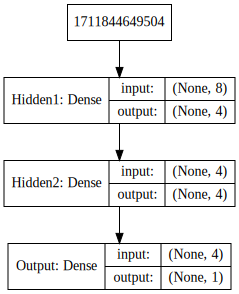

In [0]:
# We can quickly plot the model architecture
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [0]:
# We compile the model, using the adam optimizer, (binary) cross-entropy 
# loss and track the accuracy.
model.compile(optimizer ='adam',
              loss='binary_crossentropy', 
              metrics =['accuracy'])

In [0]:
# Finally we fit the model to the training dataset
history=model.fit(x_train,y_train, batch_size=10, epochs=100) 

Epoch 1/100
614/614 [==============================] - 2s 3ms/step - loss: 0.7274 - acc: 0.6417
Epoch 2/100
614/614 [==============================] - 0s 375us/step - loss: 0.6808 - acc: 0.6596
Epoch 3/100
614/614 [==============================] - 0s 370us/step - loss: 0.6749 - acc: 0.6612
Epoch 4/100
614/614 [==============================] - 0s 377us/step - loss: 0.6695 - acc: 0.6596
Epoch 5/100
614/614 [==============================] - 0s 396us/step - loss: 0.6655 - acc: 0.6596
Epoch 6/100
614/614 [==============================] - 0s 367us/step - loss: 0.6627 - acc: 0.6564
Epoch 7/100
614/614 [==============================] - 0s 374us/step - loss: 0.6600 - acc: 0.6596
Epoch 8/100
614/614 [==============================] - 0s 367us/step - loss: 0.6545 - acc: 0.6612
Epoch 9/100
614/614 [==============================] - 0s 365us/step - loss: 0.6518 - acc: 0.6629
Epoch 10/100
614/614 [==============================] - 0s 391us/step - loss: 0.6498 - acc: 0.6596
Epoch 11/100
614/614 

614/614 [==============================] - 0s 463us/step - loss: 0.6322 - acc: 0.6661
Epoch 84/100
614/614 [==============================] - 0s 424us/step - loss: 0.6313 - acc: 0.6661
Epoch 85/100
614/614 [==============================] - 0s 359us/step - loss: 0.6273 - acc: 0.6726
Epoch 86/100
614/614 [==============================] - 0s 346us/step - loss: 0.6265 - acc: 0.6710
Epoch 87/100
614/614 [==============================] - 0s 385us/step - loss: 0.6299 - acc: 0.6645
Epoch 88/100
614/614 [==============================] - 0s 377us/step - loss: 0.6288 - acc: 0.6710
Epoch 89/100
614/614 [==============================] - 0s 369us/step - loss: 0.6267 - acc: 0.6726
Epoch 90/100
614/614 [==============================] - 0s 348us/step - loss: 0.6268 - acc: 0.6710
Epoch 91/100
614/614 [==============================] - 0s 349us/step - loss: 0.6265 - acc: 0.6743
Epoch 92/100
614/614 [==============================] - 0s 357us/step - loss: 0.6285 - acc: 0.6694
Epoch 93/100
614/614 [=

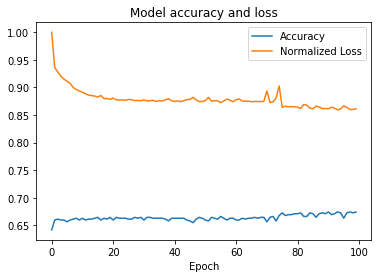

In [0]:
# We can graph the loss and accuracy values during this training.
plt.plot(history.history['acc'])
plt.plot(history.history['loss']/max(history.history['loss']))
plt.title('Model accuracy and loss')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Normalized Loss'], loc='upper right')
plt.show()

In [0]:
# Let's see how this basic model performs on our test data.
y_pred = model.predict(x_test)
y_pred = (y_pred>0.5)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[98  0]
 [49  7]]


## Review of simple implementation

The above code is both basic and **bad**. We will go through looking at how we can change things to both make it reasonable (hello validation data, regularization and early stopping) introduce more advanced Keras functionality. There are four changes we will make.

1. We are going to end up looking at models that include multiple input and output layers and/or shared layers. To work with these we will want to use keras' functional API and the keras.Model function rather than keras.Sequential. 

**Let's change the above code to use keras.Model instead of keras.Sequential.**

2. We will typically need to regularize our neural networks. Regularization provides a means of controlling the complexity of a model without changing its structure (i.e. its basic parametric equation). Common forms of regularization include:
    - L1/L2 regularization, which restricts the ability of model parameters to freely take on large values by means of penalizing large L1 or L2 norms of the weight vector. L2 regularization is also known as weight decay. You can read more about L1 and L2 regularization in Keras [here](https://machinelearningmastery.com/how-to-reduce-generalization-error-in-deep-neural-networks-with-activity-regularization-in-keras/).
    - Weight constraints, which constrains the weights to have a particular norm. You can read more about weight constraints [here](https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-neural-networks-with-weight-constraints-in-keras/).
    - Dropout, which (under one interpretation) restricts the ability of model parameters to jointly tune. You can read more
about dropout [here](https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/).
    - Noise injection, which restricts the ability of the model parameters to fit themselves to exact values found in the training data. Read more about using noise injection with keras.Sequential models and a case study [here](https://machinelearningmastery.com/how-to-improve-deep-learning-model-robustness-by-adding-noise/).

**Let's change the above code to include L2, dropout and noise injection regularization.**

 3. We often want to speed up the training process as much as possible. Batch normalization is a technique that helps speed up training, by seeking to minimize the changes to distributions that latter layers have to learn during the fitting process. Read more about batch normalization [here](https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c).

**Let's change the above code to include batch normalization.**
 
 4. We want to find the parameter (weight) values that minimize the expected error on new data, not the error on training data. We should be using validation data to evaluate the performance of the model after each epoch, and choose the final weights that correspond to optimal performance on this validation data.

**Let's evaluate the performance of our model after each epoch using validation data, and combine this with an early stopping callback that will both stop training once performance on the validation data deteriorates and load the weights associated with best performance on the validation data into our final model.** 

In [0]:
# 1. We are going to end up looking at models that include multiple 
# input and output layers and/or shared layers. To work with these 
# we will want to use keras' functional API and the keras. Model 
# function rather than keras.Sequential. 
#
# Let's change the above code to use keras.Model instead of 
# keras.Sequential.

# This returns a tensor
inputs = Input(shape=(x.shape[1],),name="Input")

# A layer instance is callable on a tensor, and returns a tensor
hidden1 = Dense(4, activation='relu',name="Hidden1")(inputs)
hidden2 = Dense(4, activation='relu',name="Hidden2")(hidden1)
outputs = Dense(1, activation='sigmoid',name="Output")(hidden2)

# This creates a model that includes the input layer through to the 
# output layer. Note that each layer knows its predecessor/input layer, 
# so the model graph can be traced back from outputs until it reaches 
# inputs.
model = Model(inputs=inputs, outputs=outputs)

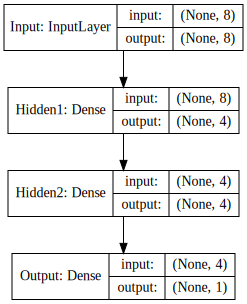

In [0]:
# Run if you want to see the model graph
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [0]:
# 2. We will typically need to regularize our neural networks. 
# Regularization provides a means of controlling the complexity of 
# a model without changing its structure (i.e. its basic parametric 
# equation). Common forms of regularization include:
#    - L1/L2 regularization
#    - Weight constraints
#    - Dropout
#    - Noise injection.
#
# Let's change the above code to include L2, dropout and noise 
# injection regularization. Note: We are going to add all of these 
# to our simple network, which is pretty odd. And we are going to
# do so in a pretty random way, which is also odd. But the point is 
# to see how each of them can be added to a network or a layer so 
# you know for the future!
inputs = Input(shape=(x.shape[1],),name="Input")

# We add a Gaussian noise layer directly after inputs.
noise = GaussianNoise(.1,name="Noise")(inputs)

# As well as having the above noise injection we add l2 regularization 
# (also known as weight decay) to the first hidden layer. Notice we have 
# to provide a hyper-parameter to specify the degree of regularization 
# to be imposed. L1 regularization is applied in an analgous way, only 
# using regularizers.l1 instead.
hidden1 = Dense(4, activation='relu',name="Hidden1",
                kernel_regularizer=l2(.1))(noise)

# We then add a dropout layer, with dropout probability .5 (another 
# hyper-parameter). This means that half the values outputted from 
# hidden layer 1 will be changed to 0 during training. The weights in 
# hidden layer 2 will have to be able to deal with this: They will not 
# be able to assume typical contributions from other input/weight pairs
# in the dot product.
dropout1 = Dropout(.5,name="Dropout1")(hidden1)

# Finally we add a weight constraint in the second hidden layer. It is 
# quite common to use weight constraints and dropout layer together.
hidden2 = Dense(4, activation='relu',name="Hidden2",
                kernel_constraint=UnitNorm())(dropout1)

outputs = Dense(1, activation='sigmoid',name="Output")(hidden2)
model = Model(inputs=inputs, outputs=outputs)

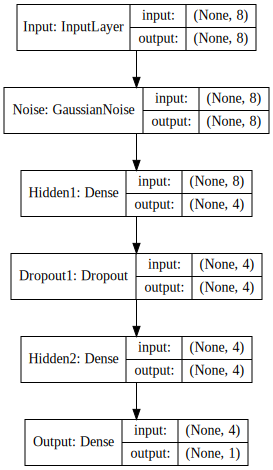

In [0]:
 # Run if you want to see the model graph after the above changes
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [0]:
# 3. We often want to speed up the training process as much as possible. 
# Batch normalization is a technique that helps speed up training, by 
# seeking to minimize the changes to the input distributions of latter 
# layers due to changes to earlier layers during the fitting process. 
#
# Let's change the above code to include batch normalization.
inputs = Input(shape=(x.shape[1],),name="Input")

# We add a Gaussian noise layer directly after inputs.
noise = GaussianNoise(.1,name="Noise")(inputs)

# By default the activation of a Dense layer is None. We do not want a 
# bias node/weight, since the batch normalization has a parameter that 
# takes care of that.
hidden1 = Dense(4,name="Hidden1",use_bias=False, 
                kernel_regularizer=l2(.1))(noise)

# By adding the Batch Normalization layer here, we apply a transformation 
# that maintains the mean close to 0 and the activation standard deviation 
# close to 1. This is done *prior* to the application of the activation 
# function, since is None above.
batch1 = BatchNormalization(name="BatchNorm1")(hidden1)
# Now we apply the activation function.
act1 = Activation("relu",name="Activation1")(batch1)

# Note we change the name of the tensor going into dropout1
dropout1 = Dropout(.5,name="Dropout1")(act1)

# We do the same thing with the second hidden layer
hidden2 = Dense(4,name="Hidden2",use_bias=False, 
                kernel_constraint=UnitNorm())(dropout1)
batch2 = BatchNormalization(name="BatchNorm2")(hidden2)
act2 = Activation("relu",name="Activation2")(batch2)

# Note we change the name of the tensor going into outputs
outputs = Dense(1, activation='sigmoid',name="Output")(act2)
model = Model(inputs=inputs, outputs=outputs)

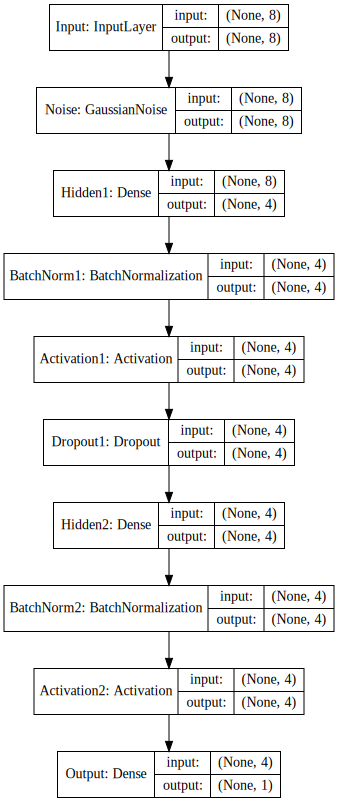

In [0]:
# Run if you want to see the model graph after the above changes
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [0]:
# 4. We want to find the parameter (weight) values that minimize the 
# expected error on new data, not the error on training data. We should 
# be using validation data to evaluate the performance of the model after 
# each epoch, and choose the final weights that correspond to optimal 
# performance on this validation data.
# 
# Let's evaluate the performance of our model after each epoch using 
# validation data, and combine this with an early stopping callback that 
# will both stop training once performance on the validation data 
# deteriorates and load the weights associated with best performance 
# on the validation data into our final model.

# We compile the model, using the adam optimizer, (binary) cross-entropy 
# loss and track the accuracy.
model.compile(optimizer ='adam',
              loss='binary_crossentropy', 
              metrics =['accuracy'])

# We create the Early Stopping callback. We set it up to stop if 
# improvement in the validation loss does not occur over 15 epochs. 
# When stopping occurs, the weights associated with the best validation 
# loss are restored.
earlyStopping = EarlyStopping(monitor="val_loss", 
                              patience=15,
                              verbose=1,
                              restore_best_weights=True)

# Using validation_split in the model.fit function can be dangerous as 
# it takes last rows prior to shuffling. If data order is not random, this
# can lead to introduction of bias into the data. It is OK here since 
# the data was shuffled during the train/test split above.    
history=model.fit(x_train, 
                  y_train, 
                  epochs=100, 
                  batch_size=10, 
                  shuffle=True, 
                  validation_split=.2, 
                  callbacks=[earlyStopping])

Train on 491 samples, validate on 123 samples
Epoch 1/100
491/491 [==============================] - 1s 2ms/step - loss: 1.2616 - acc: 0.5132 - val_loss: 1.1237 - val_acc: 0.5285
Epoch 2/100
491/491 [==============================] - 0s 884us/step - loss: 1.1662 - acc: 0.4969 - val_loss: 1.0257 - val_acc: 0.6992
Epoch 3/100
491/491 [==============================] - 0s 908us/step - loss: 1.0068 - acc: 0.6090 - val_loss: 0.9403 - val_acc: 0.7154
Epoch 4/100
491/491 [==============================] - 0s 932us/step - loss: 0.9631 - acc: 0.6029 - val_loss: 0.8669 - val_acc: 0.7154
Epoch 5/100
491/491 [==============================] - 0s 680us/step - loss: 0.8928 - acc: 0.6538 - val_loss: 0.8045 - val_acc: 0.7480
Epoch 6/100
491/491 [==============================] - 0s 717us/step - loss: 0.8466 - acc: 0.6497 - val_loss: 0.7585 - val_acc: 0.7398
Epoch 7/100
491/491 [==============================] - 0s 666us/step - loss: 0.8034 - acc: 0.6477 - val_loss: 0.7183 - val_acc: 0.7398
Epoch 8/100

Epoch 61/100
491/491 [==============================] - 0s 700us/step - loss: 0.5471 - acc: 0.7617 - val_loss: 0.4679 - val_acc: 0.8374
Epoch 62/100
491/491 [==============================] - 0s 818us/step - loss: 0.5923 - acc: 0.7210 - val_loss: 0.4698 - val_acc: 0.8618
Epoch 63/100
491/491 [==============================] - 0s 889us/step - loss: 0.5579 - acc: 0.7312 - val_loss: 0.4729 - val_acc: 0.8293
Epoch 64/100
491/491 [==============================] - 0s 718us/step - loss: 0.5632 - acc: 0.7169 - val_loss: 0.4788 - val_acc: 0.8130
Epoch 65/100
491/491 [==============================] - 0s 719us/step - loss: 0.5752 - acc: 0.7088 - val_loss: 0.4980 - val_acc: 0.7724
Epoch 66/100
491/491 [==============================] - 0s 712us/step - loss: 0.5384 - acc: 0.7678 - val_loss: 0.4837 - val_acc: 0.7886
Epoch 67/100
491/491 [==============================] - 0s 654us/step - loss: 0.5423 - acc: 0.7291 - val_loss: 0.4637 - val_acc: 0.7967
Epoch 68/100
491/491 [==========================

Our model is a bit of a mess - we've added all sorts of regularization and batch normalization, and done no hyper-parameter tuning. But that's OK - we want to see how to do the four points, not make a high quality model for this problem!

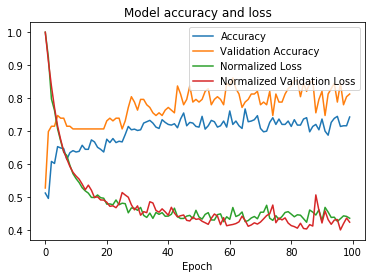

In [0]:
# We can graph the loss and accuracy values during this training.
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.plot(history.history['loss']/max(history.history['loss']))
plt.plot(history.history['val_loss']/max(history.history['val_loss']))
plt.title('Model accuracy and loss')
plt.xlabel('Epoch')
plt.legend(['Accuracy','Validation Accuracy', 'Normalized Loss',
            'Normalized Validation Loss'], loc='upper right')
plt.show()

In [0]:
# Let's see how this weird model performs on our test data.
y_pred = model.predict(x_test)
y_pred = (y_pred>0.5)

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[86 12]
 [28 28]]
